# Garbage Classification using Transfer Learning

This notebook demonstrates garbage image classification using MobileNetV2 and transfer learning, inspired by the referenced public notebook. It covers data loading, augmentation, model building, training, evaluation, and visualization.

In [4]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [13]:
import kagglehub

path = kagglehub.dataset_download("farzadnekouei/trash-type-image-dataset")

os.replace(f"{path}/TrashType_Image_Dataset", "../dataset")

100%|██████████| 40.9M/40.9M [00:05<00:00, 8.31MB/s]

Extracting files...


## Data Preparation and Augmentation

We use ImageDataGenerator for data augmentation and to load images from the dataset directory.

In [15]:
# Set dataset path and image size
dataset_path = "../dataset"
img_size = (224, 224)
batch_size = 32

# Data augmentation for training, only rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
class_names = list(train_generator.class_indices.keys())

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


## Visualize Sample Images

Display a grid of sample images from the training set with their labels.

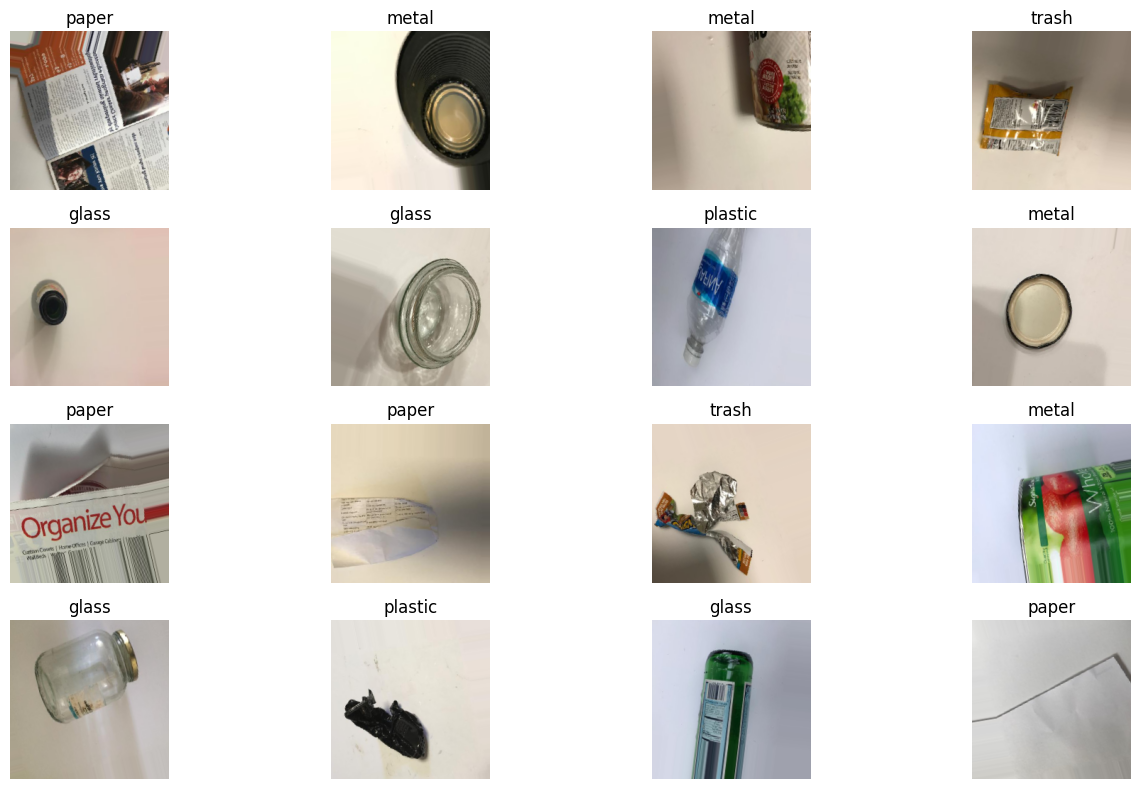

In [16]:
# Plot a grid of sample images with labels
images, labels = next(train_generator)
plt.figure(figsize=(14, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Build the Model

We use MobileNetV2 as the base model for transfer learning, with custom dense layers on top.

In [17]:
# Build the transfer learning model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
base_model.trainable = False  # Freeze base model

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1750338271.681673   19406 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Train the Model

Train the model and record the training history.

In [18]:
epochs = 30

base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

/home/shiva/Projects/scrapscope/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1750338295.495907   23711 service.cc:152] XLA service 0x7fed0c057ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750338295.496137   23711 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-06-19 13:04:55.839809: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750338297.380238   23711 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-19 13:04:59.202674: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3728', 204 bytes spill stores, 204 bytes spill loads

2025-06-19 13:04:59.221357: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

41/64 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.1777 - loss: 2.2083

2025-06-19 13:05:25.528469: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3728', 8 bytes spill stores, 8 bytes spill loads

2025-06-19 13:05:25.572005: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3728_0', 176 bytes spill stores, 524 bytes spill loads

2025-06-19 13:05:25.736919: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3728', 12 bytes spill stores, 12 bytes spill loads

2025-06-19 13:05:25.811133: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3728', 112 bytes spill stores, 112 bytes spill loads

2025-06-19 13:05:26.485497: I extern

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.1857 - loss: 2.1782

2025-06-19 13:05:44.441575: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1202', 4 bytes spill stores, 4 bytes spill loads

2025-06-19 13:05:48.230292: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1202', 4 bytes spill stores, 4 bytes spill loads

2025-06-19 13:05:48.277017: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195', 220 bytes spill stores, 220 bytes spill loads

2025-06-19 13:05:48.350129: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1195_0', 444 bytes spill stores, 1384 bytes spill loads

2025-06-19 13:05:48.724132: I externa

64/64 ━━━━━━━━━━━━━━━━━━━━ 66s 610ms/step - accuracy: 0.1860 - loss: 2.1766 - val_accuracy: 0.2704 - val_loss: 1.7495
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.3280 - loss: 1.7285 - val_accuracy: 0.3897 - val_loss: 1.5163
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.4101 - loss: 1.5320 - val_accuracy: 0.4473 - val_loss: 1.3562
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - accuracy: 0.4576 - loss: 1.3839 - val_accuracy: 0.5030 - val_loss: 1.2419
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.5139 - loss: 1.2683 - val_accuracy: 0.5328 - val_loss: 1.1680
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step - accuracy: 0.5985 - loss: 1.1386 - val_accuracy: 0.5447 - val_loss: 1.1164
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.6065 - loss: 1.0810 - val_accuracy: 0.5686 - val_loss: 1.0604
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.6492 - loss: 0.9795 - val_accuracy: 0.594

## Plot Training and Validation Accuracy/Loss

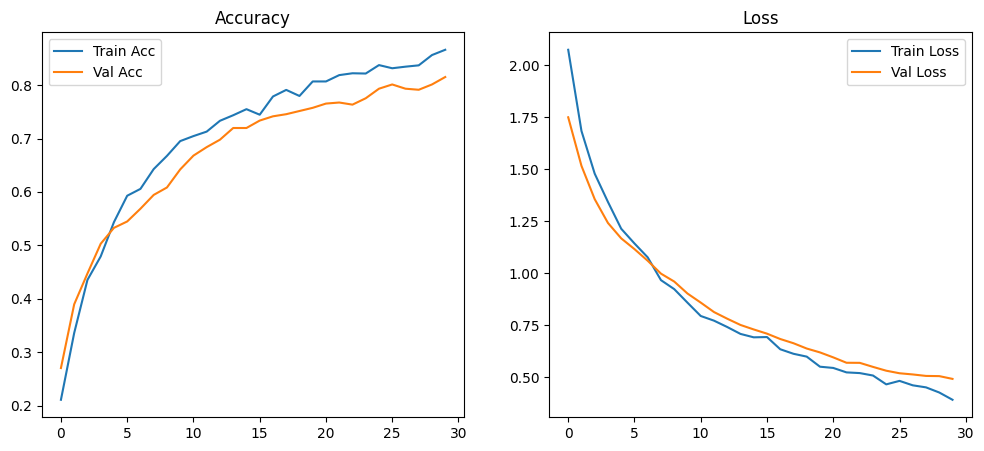

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Evaluate the Model

Generate predictions, print a classification report, and plot a confusion matrix.

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step
              precision    recall  f1-score   support

   cardboard       0.93      0.93      0.93        80
       glass       0.86      0.77      0.81       100
       metal       0.82      0.89      0.85        82
       paper       0.84      0.85      0.84       118
     plastic       0.72      0.77      0.74        96
       trash       0.55      0.44      0.49        27

    accuracy                           0.82       503
   macro avg       0.78      0.77      0.78       503
weighted avg       0.81      0.82      0.81       503



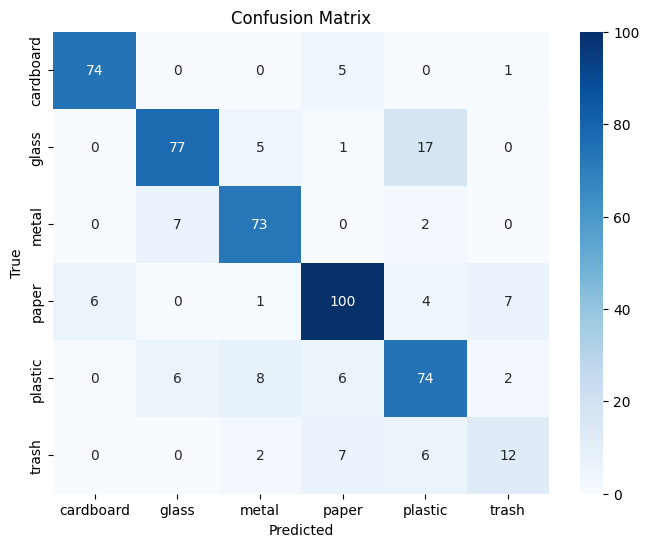

In [20]:
# Evaluate on validation data
val_steps = validation_generator.samples // batch_size + 1
Y_pred = model.predict(validation_generator, steps=val_steps)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes[:len(y_pred)]

print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Visualize Predictions

Show a grid of validation images with their predicted and true labels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


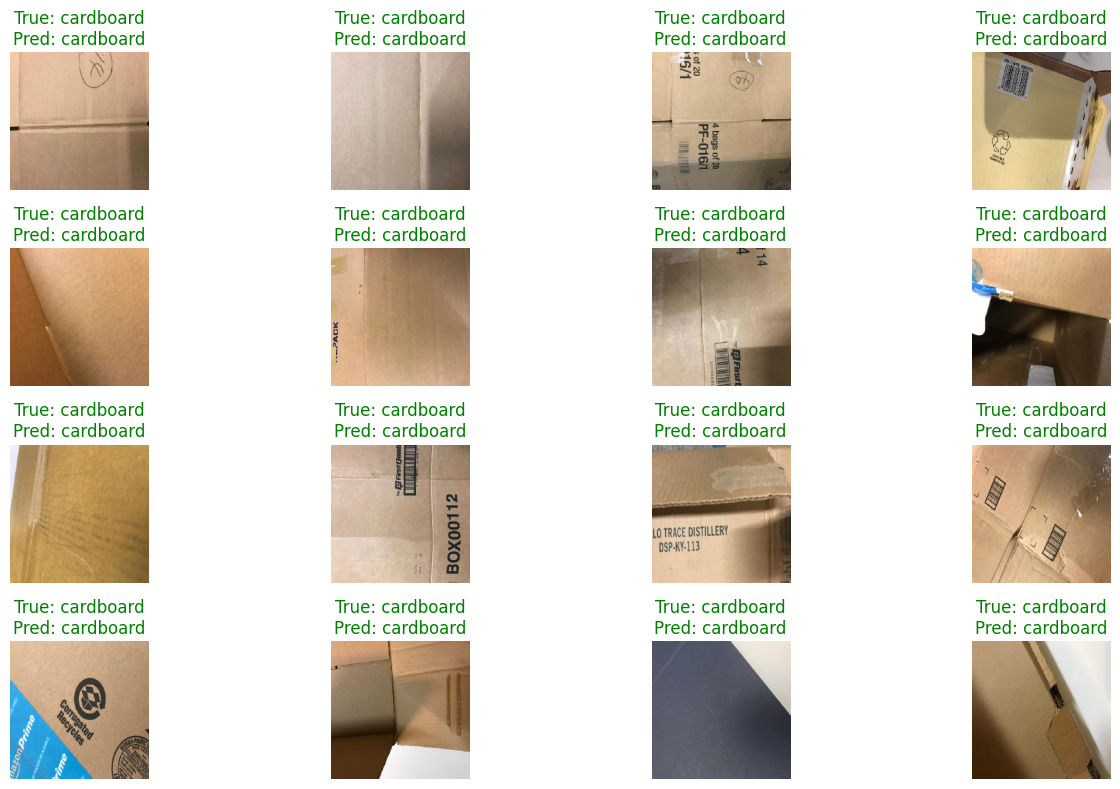

In [21]:
# Visualize predictions on validation images
val_images, val_labels = next(validation_generator)
preds = model.predict(val_images)
plt.figure(figsize=(14, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(val_images[i])
    true_label = class_names[np.argmax(val_labels[i])]
    pred_label = class_names[np.argmax(preds[i])]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Save the Model

Save the trained model for later inference.

In [23]:
model.save('garbage_classifier.keras')
print('Model saved as garbage_classifier.keras')

Model saved as garbage_classifier.keras
